In [118]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [119]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [120]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [121]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [122]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [123]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [124]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

for column in measurement.__table__.columns:
    print(f"Column: {column.name}, Type: {column.type}")


Column: id, Type: INTEGER
Column: station, Type: TEXT
Column: date, Type: TEXT
Column: prcp, Type: FLOAT
Column: tobs, Type: FLOAT


In [125]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Precipitation Analysis

In [126]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(measurement.date)).one()
most_recent_date


('2017-08-23',)

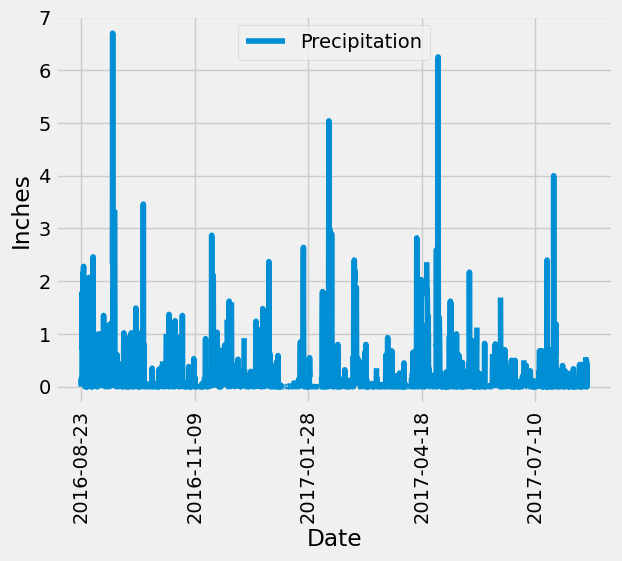

In [127]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
most_recent_date = session.query(func.max(measurement.date)).scalar()
one_year_ago = dt.datetime.strptime(most_recent_date,'%Y-%m-%d') - dt.timedelta(days=366)


# Perform a query to retrieve the data and precipitation scores
precipitation = session.query(measurement.date, measurement.prcp)\
    .filter(measurement.date >= one_year_ago)\
    .order_by(measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(precipitation, columns=['Date', 'Precipitation'])


# Sort the dataframe by date
df = df.sort_values(by='Date')

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(x='Date', y='Precipitation')
plt.xlabel("Date")
plt.ylabel("Inches")
plt.xticks(rotation=90)
plt.show()


In [128]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = df['Precipitation'].describe()
summary_df = pd.DataFrame(summary_statistics)
summary_df



,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [129]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(station.station)).all()
total_stations

[(9,)]

In [130]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active = session.query(measurement.station, func.count(measurement.station))\
    .group_by(measurement.station)\
    .order_by(func.count(measurement.station).desc()).all()
most_active


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [131]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_id = most_active[0][0]

temperature_stats = session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs))\
    .filter(measurement.station == most_active_id)\
    .all()

temperature_stats

[(54.0, 85.0, 71.66378066378067)]

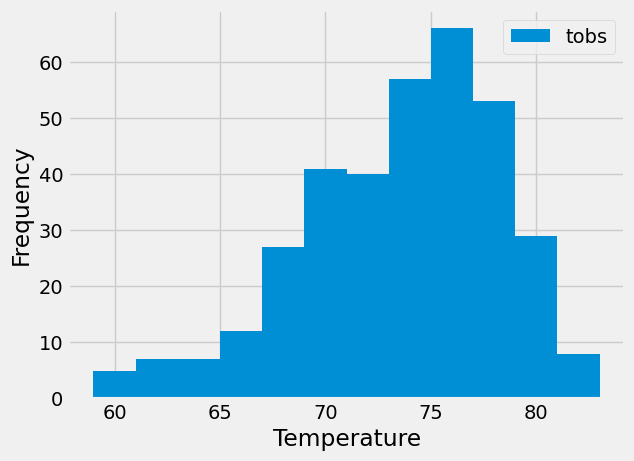

In [132]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = session.query(measurement.date, measurement.tobs)\
    .filter(measurement.station == most_active_id)\
    .filter(measurement.date >= one_year_ago)\
    .all()

#create a pandas DataFrame directly from the query results
temperature_df = pd.DataFrame(temperature_data, columns=['Date','Temperature'])

#Plot Histogram
plt.hist(temperature_df['Temperature'], label='tobs', bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Close Session

In [133]:
# Close Session
session.close()